In [1]:
import glob
import sahi
import os
import json

import numpy as np

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from sklearn.metrics import auc

In [2]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

## Auxiliary functions

In [3]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [4]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [6]:
predictions = get_prediction(read_image("datasets/images/people_frames_10.jpg"), detection_model)

In [7]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [8]:
image = cv2.imread("datasets/images/people_frames_10.jpg")
height, width = image.shape[:2]

In [9]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [10]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [11]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

### Unite all in one function

In [57]:
def compute_AP50_for_image(gt_path, predictions, image_path):
    '''
    compute AP50 for one image
    :param gt_path: path to GT labels in the file
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=='0'] #select only people (class 0)
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(1000))
    i=0
    for result in predictions:
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = image_path
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            ious=[]
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0
            i+=1
        else:
            continue

    num_gt = len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt


    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



### Get usual predictions

In [13]:
predictions = get_prediction(read_image("datasets/images/people_frames_10.jpg"), detection_model)
#results in form tlwh
results = predictions.to_coco_annotations()

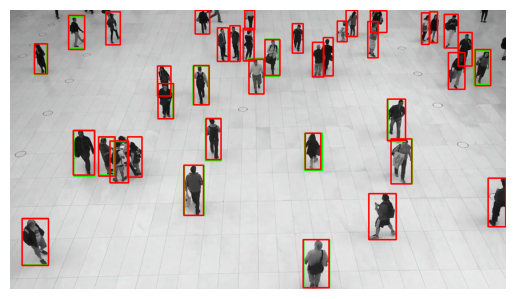

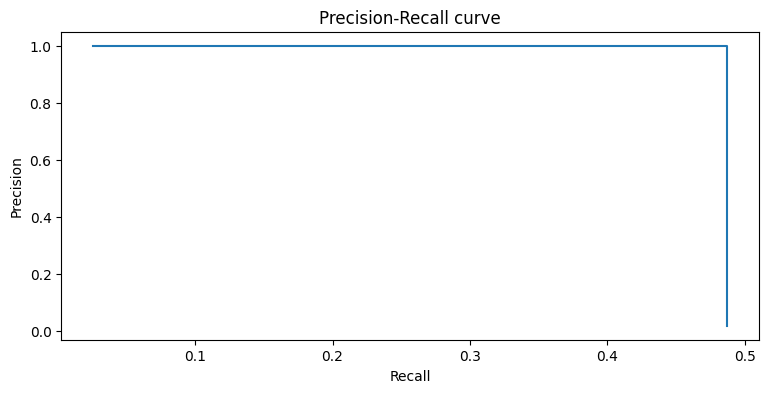

AP50 = 0.4615


In [14]:
compute_AP50_for_image("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

## Get sliced predictions

In [15]:
result = get_sliced_prediction(
    "datasets/images/people_frames_10.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.8,
    overlap_width_ratio = 0.8
)

Performing prediction on 12 number of slices.


In [16]:
results = result.to_coco_annotations()

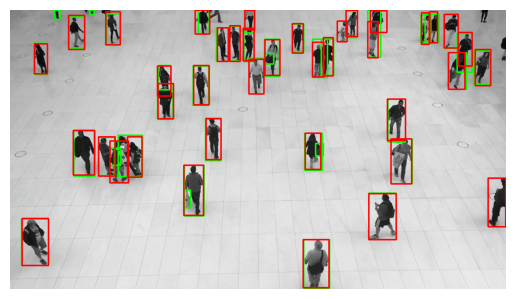

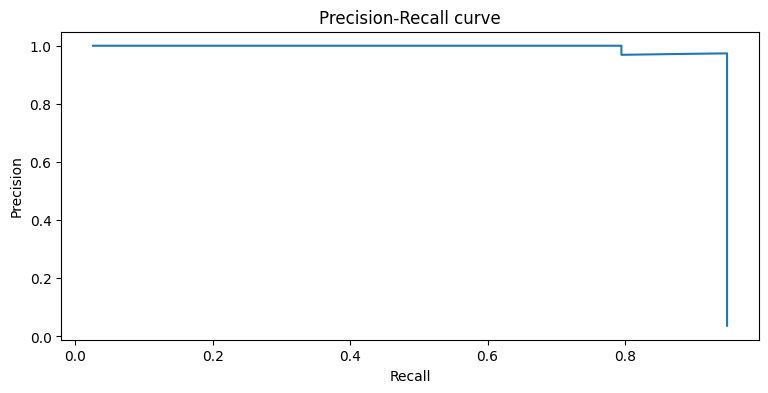

AP50 = 0.9187


In [17]:
compute_AP50_for_image("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

In [18]:
!wget http://images.cocodataset.org/zips/val2014.zip -O coco_val2014.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -O coco_ann2014.zip

UsageError: Cell magic `%%wget` not found.


In [18]:
# Opening JSON file
f = open('coco-2017/validation/new_labels.json')

# returns JSON object as
# a dictionary
data = json.load(f)

In [19]:
data

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01',
  'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
    'id': 1,
    'name': 'Attribution-NonCommercial-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
    'id': 2,
    'name': 'Attribution-NonCommercial License'},
   {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
    'id': 3,
    'name': 'Attribution-NonCommercial-NoDerivs License'},
   {'url': 'http://creativecommons.org/licenses/by/2.0/',
    'id': 4,
    'name': 'Attribution License'},
   {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
    'id': 5,
    'name': 'Attribution-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
    'id': 6,
    'name': 'Attribution-NoDerivs License'},
   {'url': 'http://flickr.com/commons/usage/',
    'id': 7

In [20]:
def change_annotations_to_yolo(json_file, out_file):
    '''
    changes annotations from coco to yolo format: id from 0 to ....
    :param json_file: old file
    :param out_file: output file with new categories
    '''

    # Opening JSON file
    f = open(json_file)

    # returns JSON object as a dictionary
    data = json.load(f)

    annotations = data['annotations']
    for annotation in annotations:
        annotation['category_id']-=1

    data['annotations'] = annotations

    categories = data['categories']
    for category in categories:
        category['id']-=1

    data['categories'] = categories

    info_categories = data['info']['categories']
    for category in info_categories:
        category['id']-=1

    data['info']['categories'] = info_categories

    json_object = json.dumps(data, indent=4)

    # Writing to sample.json
    with open(out_file, "w") as outfile:
        outfile.write(json_object)



In [107]:
change_annotations_to_yolo("coco-2017/validation/labels.json", "coco-2017/validation/new_labels.json")

In [72]:
def convert_labels(x1, y1, x2, y2):
    '''
    Definition: Parses label files to extract label and bounding box
    coordinates. Converts (x1, y1, x1, y2) KITTI format to
    (x, y, width, height) normalized YOLO format.
    '''
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin

    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)

    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin

    return (x,y,w,h) #x_c, y_c, w, h

### Convert COCO annotations to YOLO format (x_c, y_c, width, height)/(width, height)

In [21]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [74]:
for i in range(len(training_data['annotations'])):
    image_id = str(training_data['annotations'][i]['image_id'])
    category_id = str(training_data['annotations'][i]['category_id'])
    bbox = training_data['annotations'][i]['bbox']
    # for image in training_data['images']:
    #     if str(image['id'])==str(image_id).strip():
    #         width = image['width']
    #         height = image['height']
    #         break

    kitti_bbox = [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]] #tlbr
    yolo_bbox = convert_labels(kitti_bbox[0], kitti_bbox[1], kitti_bbox[2], kitti_bbox[3])
    training_data['annotations'][i]['bbox'] = yolo_bbox

In [75]:
json_object = json.dumps(training_data, indent=4)

    # Writing to sample.json
with open("coco-2017/validation/new_labels.json", "w") as outfile:
    outfile.write(json_object)

In [1]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [2]:
extract_val_path = "./coco_val2014"
extract_ann_path="./coco_ann2014"

extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

### Download part of COCO dataset only with people

In [102]:
import fiftyone as fo
import fiftyone.zoo as foz

In [106]:
# To download the COCO dataset for only the "person" and "car" classes
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    max_samples=200,
    only_matching=True
)

09/01/2023 16:45:03 - INFO - fiftyone.zoo.datasets -   Downloading split 'validation' to 'C:\Users\user\fiftyone\coco-2017\validation' if necessary


09/01/2023 16:45:03 - INFO - fiftyone.utils.coco -   Downloading annotations to 'C:\Users\user\fiftyone\coco-2017\tmp-download\annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


09/01/2023 16:46:02 - INFO - eta.core.utils -    100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:02 - INFO - fiftyone.utils.coco -   Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:09 - INFO - fiftyone.utils.coco -   Downloading 200 images


 100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


09/01/2023 16:46:21 - INFO - eta.core.utils -    100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


09/01/2023 16:46:21 - INFO - fiftyone.utils.coco -   Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Functions to predict and to evaluate

In [ ]:
# !sahi predict --source coco-2017/validation/data --dataset_json_path coco-2017/validation/new_labels.json --model_type yolov8 --model_path yolov8m.pt --slice_height 256 --slice_width 256 --overlap_height_ratio 0.2 --overlap_width_ratio 0.2 --model_confidence_threshold 0.25
#
#
# !sahi coco evaluate --dataset_json_path coco-2017/validation/new_labels.json --result_json_path runs/predict/exp_512_08/result.json --out_dir output/results_512_08

### SAHI results for different slice and overlap

In [30]:
sahi_results = pd.DataFrame(columns=["slice", "overlap", "mAP50", "mAP50s", "mAP50m", "mAP50l"], index=range(6))

In [31]:
for i, dir in enumerate(os.listdir("output")):
    parts = dir.split("_")
    slice = int(parts[1])
    overlap = int(parts[2])/10
    sahi_results.loc[i]['slice']=slice
    sahi_results.loc[i]['overlap']=overlap

    f = open(f"output/{dir}/eval.json")
    results = json.load(f)
    sahi_results.loc[i]['mAP50'] = results["bbox_mAP50"]
    sahi_results.loc[i]['mAP50s'] = results["bbox_mAP50_s"]
    sahi_results.loc[i]['mAP50m'] = results["bbox_mAP50_m"]
    sahi_results.loc[i]['mAP50l'] = results["bbox_mAP50_l"]

In [32]:
sahi_results

,slice,overlap,mAP50,mAP50s,mAP50m,mAP50l
0,256,0.2,0.095,0.108,0.113,0.165
1,256,0.5,0.091,0.104,0.111,0.152
2,256,0.8,0.092,0.115,0.125,0.153
3,512,0.2,0.112,0.115,0.11,0.183
4,512,0.5,0.112,0.115,0.11,0.183
5,512,0.8,0.115,0.125,0.11,0.172


In [33]:
sahi_results.set_index(['slice', 'overlap'], inplace=True)

In [34]:
sahi_results

mAP50 mAP50s mAP50m mAP50l
slice overlap                            
256   0.2      0.095  0.108  0.113  0.165
      0.5      0.091  0.104  0.111  0.152
      0.8      0.092  0.115  0.125  0.153
512   0.2      0.112  0.115   0.11  0.183
      0.5      0.112  0.115   0.11  0.183
      0.8      0.115  0.125   0.11  0.172

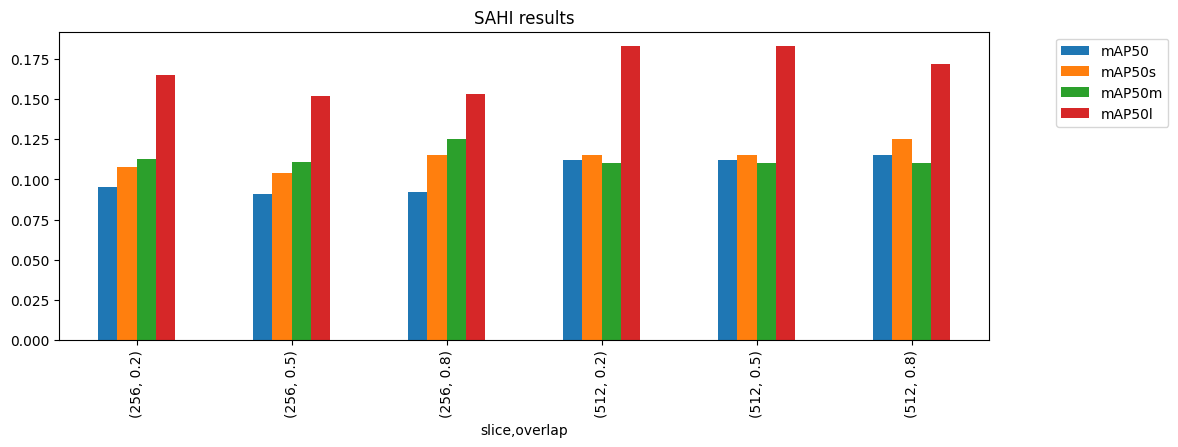

In [35]:
sahi_results.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

### Draw bbox of coco-2017 labels and predicted bbox

In [22]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [23]:
training_data['images']

[{'license': 1,
  'file_name': '000000017627.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000017627.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 15:13:53',
  'flickr_url': 'http://farm5.staticflickr.com/4145/4977243989_c2efb1b911_z.jpg',
  'id': 17627},
 {'license': 3,
  'file_name': '000000025560.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000025560.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-17 21:48:19',
  'flickr_url': 'http://farm1.staticflickr.com/198/488201322_ef2ebfeccb_z.jpg',
  'id': 25560},
 {'license': 3,
  'file_name': '000000016228.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000016228.jpg',
  'height': 440,
  'width': 640,
  'date_captured': '2013-11-19 00:09:53',
  'flickr_url': 'http://farm4.staticflickr.com/3737/10031812195_372ae7538f_z.jpg',
  'id': 16228},
 {'license': 1,
  'file_name': '000000035197.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000035

In [89]:
image_id=33759
for image in training_data['images']:
    if str(image['id'])==str(image_id):
        image_path = image['file_name']
        break

(-0.5, 639.5, 456.5, -0.5)

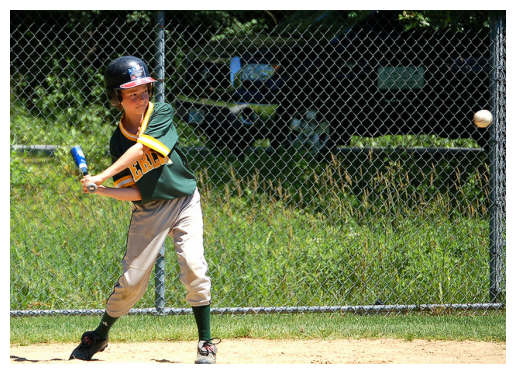

In [90]:
image = cv2.imread(f"coco-2017/validation/data/{image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

In [91]:
def draw_annotations(image, image_id, json_file, color):
    '''
    draw annotations on image with image_id from json_file
    :param image_id:
    :return:
    '''

    f = open(json_file)

    data = json.load(f)

    try:
        annotations = training_data['annotations']
    except TypeError:
        annotations = data

    for annotation in annotations:
        if annotation['image_id']==image_id and annotation['category_id']==0: #only persons
            box=annotation['bbox']
            x1, y1 = float(box[0]), float(box[1])
            width, height = float(box[2]), float(box[3])
            x2 = x1+width
            y2 = y1+height
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color=color, thickness=2)
    plt.imshow(image)
    plt.axis("off")

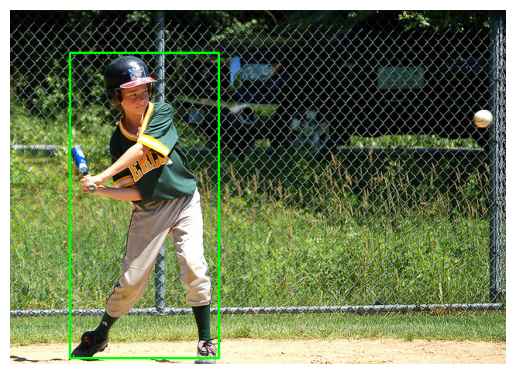

In [92]:
draw_annotations(image, 33759, "coco-2017/validation/new_labels.json", color=(0, 255, 0))

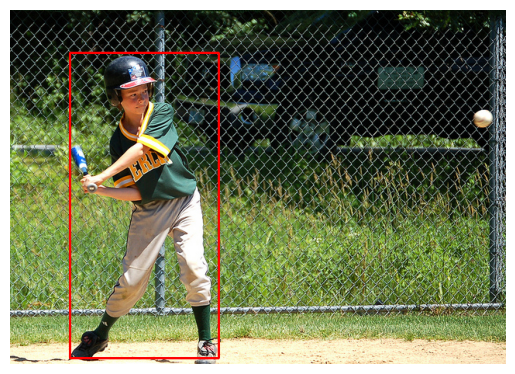

In [93]:
draw_annotations(image, 33759, "runs/predict/yolo_coco_finetuned/finetuned_256_02/result.json", color=(255, 0, 0))

In [45]:
# def make_prediction(image_dir, destination_dir):
#
#     for image in glob.glob(f"{image_dir}/*.jpg"):
#
#         predictions = get_sliced_prediction(
#         image,
#         detection_model,
#         slice_height = 512,
#         slice_width = 512,
#         overlap_height_ratio = 0.2,
#         overlap_width_ratio = 0.2
#         )
#
#         print(image)
#         file_name = image.split("\\")[-1].split(".")[0]
#         print(file_name)
#
#         results = predictions.to_coco_annotations()
#
#         with open(f"{destination_dir}/{file_name}.txt", "w+") as f:
#             for result in results:
#                 f.write(str(result['category_id'])+" ")
#                 f.write(" {:.8f}".format(result['score']))
#                 for box in result['bbox']:
#                     f.write(" {:.8f}".format(box))
#                 f.write("\n")


In [ ]:
# make_prediction("test_dataset/images", "test")

In [56]:
def compute_AP50(gt_json, predictions_json, threshold=0.5, plot=True):
    '''
    compute AP50 for batch of images (computes only for person class)
    :param gt_json: json-file with predictions in coco format: tlwh
    :param predictions_json: predictions in coco format: tlwh
    :plot: if True plot Precision-Recall curve
    :return: AP50
    '''

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(10000))

    f = open(gt_json)
    data = json.load(f)
    annotations = data['annotations']
    images = data['images']

    num_gt=0
    i=0

    images_id=[]

    for image in images:
        images_id.append(image['id'])

    images_id = list(set(images_id))

    for image_id in images_id:
        gt_boxes=[]
        for annotation in annotations:
            if annotation['image_id']==image_id and annotation['category_id']==0: #collect gt only for persons
                gt_boxes.append(list(map(lambda x: float(x), annotation['bbox'])))
                #convert from xywh to tlbr
        gt_boxes = [tlwh_tlbr(box) for box in gt_boxes]
        num_gt += len(gt_boxes)


        f = open(predictions_json)
        predictions = json.load(f)
        for result in predictions:
            if result['image_id']==image_id and result['category_id']==0: #select only persons
                pr_box=list(map(lambda x: float(x), result['bbox']))
                pr_box=tlwh_tlbr(pr_box)
                predicted_boxes.loc[i]['confidence']=float(result['score'])
                predicted_boxes.loc[i]['image']=result['image_id']
                ious=[]
                for gt_box in gt_boxes:
                    iou = intersection_over_union(gt_box, pr_box)
                    ious.append(iou)
                if max(ious)>threshold:  #0.50-0.95
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['TP']=1
                    predicted_boxes.loc[i]['FP']=0
                else:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['FP']=1
                    predicted_boxes.loc[i]['TP']=0

                i+=1
            else:
                continue

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False, inplace=True)

    predicted_boxes.reset_index(inplace=True)


    for i in range(len(predicted_boxes)):
        predicted_boxes.loc[i, 'Precision']=predicted_boxes[:i+1]['TP'].sum()/(i+1)
        predicted_boxes.loc[i, 'Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt



    if plot:
        plt.figure(figsize=(9, 4))
        plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
        plt.title("Precision-Recall curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()

    predicted_boxes.dropna(thresh=3, inplace=True)


    ap = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    if plot:
        print(f"AP50 = {ap :.4f}")

    return ap

### Compute AP50-95

In [54]:
def compute_AP50_95(gt_json, predictions_json):
    ap_total = 0
    for threshold in np.arange(0.5, 1.0, 0.05):
        ap_total+=compute_AP50(gt_json,
                               predictions_json,
                               threshold=threshold,
                               plot=False)
    return ap_total/10

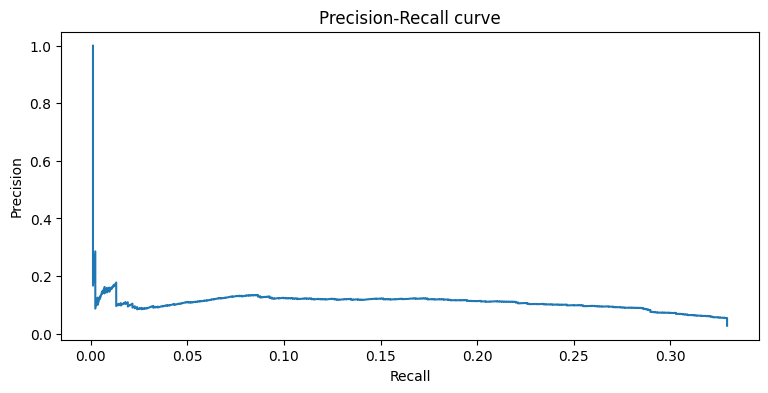

AP50 = 0.0350


In [94]:
AP50 = compute_AP50("coco-2017/validation/new_labels.json", "runs/predict/yolo_coco_finetuned/finetuned_256_05/result.json", plot=True)

In [55]:
AP50_95 = compute_AP50_95("coco-2017/validation/new_labels.json", "runs/predict/exp_256_05/result.json")
print(AP50_95)

0.38937658148616183


### Compute metrics for SAHI (YOLOv8 pretrained) on COCO

In [69]:
def compute_metrics(dataframe, results_path, gt_path):
    '''
    :param dataframe: dataframe where AP50 and AP50-95 metrics will be saved
    :param results_path: folder where predictions are saved
    :param gt_path: path to gt labels in coco format
    :return: dataframe with computed metrics
    '''

    for i, dir in enumerate(os.listdir(results_path)):
        parts = dir.split("_")
        slice = int(parts[1])
        overlap = int(parts[2]) / 10
        dataframe.loc[i]['slice'] = slice
        dataframe.loc[i]['overlap'] = overlap


        dataframe.loc[i]['AP50'] = compute_AP50(gt_path,
                                           f"{results_path}/{dir}/result.json",
                                            threshold=0.5,
                                            plot=False)
        dataframe.loc[i]['AP50-95'] = compute_AP50_95(gt_path,
                                            f"{results_path}/{dir}/result.json")
    return dataframe

In [70]:
sahi_yolo_pretrained_coco = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(6))


# for i, dir in enumerate(os.listdir("runs/predict/yolo_coco_pretrained")):
#     print(dir)
#     parts = dir.split("_")
#     slice = int(parts[1])
#     overlap = int(parts[2]) / 10
#     sahi_yolo_pretrained_coco.loc[i]['slice'] = slice
#     sahi_yolo_pretrained_coco.loc[i]['overlap'] = overlap
#
#
#     sahi_yolo_pretrained_coco.loc[i]['AP50'] = compute_AP50("coco-2017/validation/new_labels.json",
#                                                        f"runs/predict/yolo_coco_pretrained/{dir}/result.json", threshold=0.5, plot=False)
#     sahi_yolo_pretrained_coco.loc[i]['AP50-95'] = compute_AP50_95("coco-2017/validation/new_labels.json",
#                                                        f"runs/predict/yolo_coco_pretrained/{dir}/result.json")

In [71]:
sahi_yolo_pretrained_coco = compute_metrics(sahi_yolo_pretrained_coco,
                                            "runs/predict/yolo_coco_pretrained",
                                            "coco-2017/validation/new_labels.json")

In [72]:
sahi_yolo_pretrained_coco.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_pretrained_coco

AP50   AP50-95
slice overlap                    
256   0.2      0.690546  0.408662
      0.5      0.659684  0.389377
      0.8      0.734101  0.390798
512   0.2      0.653514  0.423869
      0.5      0.653514  0.423869
      0.8      0.655145  0.420781

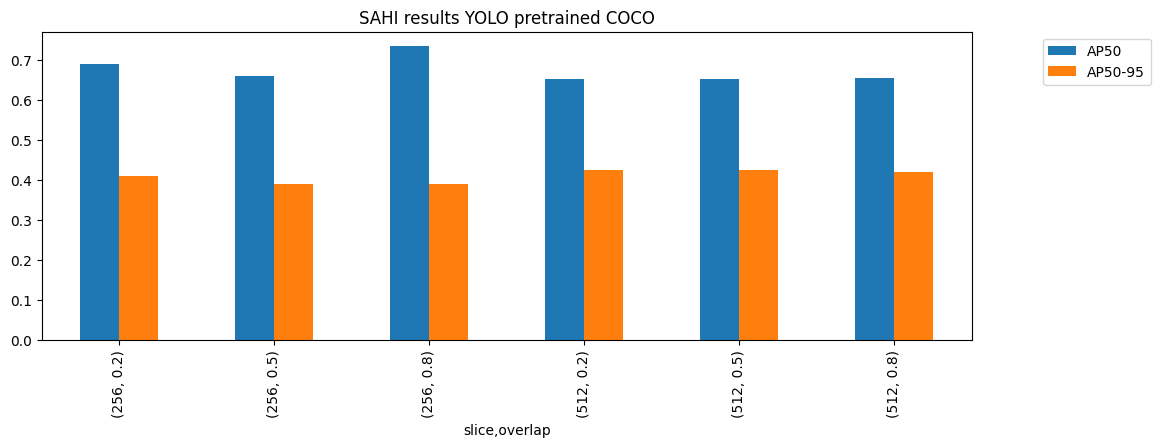

In [73]:
sahi_yolo_pretrained_coco.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results YOLO pretrained COCO");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

### Compute metrics for SAHI (YOLOv8 fine-tuned) on COCO

In [74]:
sahi_yolo_finetuned_coco = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(6))

sahi_yolo_finetuned_coco = compute_metrics(sahi_yolo_finetuned_coco,
                                            "runs/predict/yolo_coco_finetuned",
                                            "coco-2017/validation/new_labels.json")

In [75]:
sahi_yolo_finetuned_coco.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_finetuned_coco

AP50   AP50-95
slice overlap                    
256   0.2      0.032731  0.007979
      0.5      0.035042  0.007623
      0.8      0.029342  0.007096
512   0.2      0.088262  0.024043
      0.5      0.088262  0.024043
      0.8      0.085552  0.023126

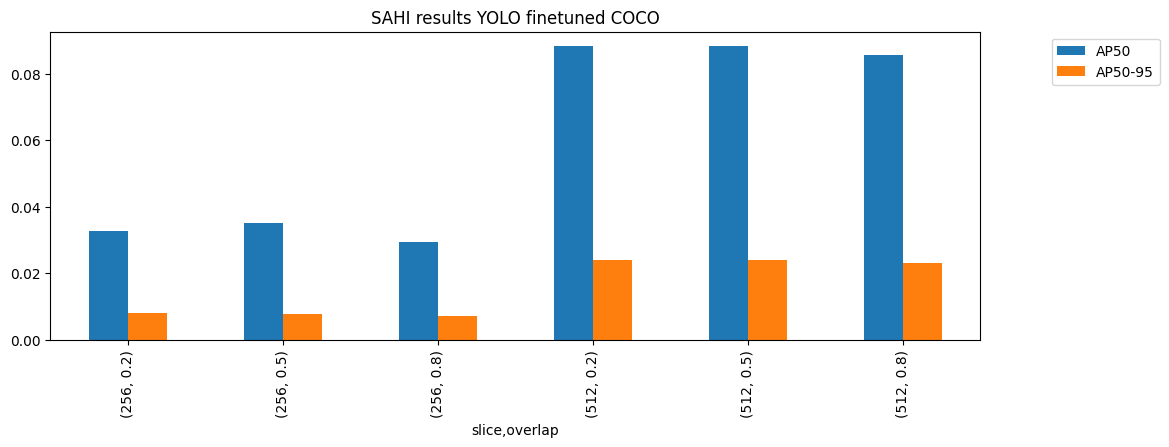

In [76]:
sahi_yolo_finetuned_coco.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results YOLO finetuned COCO");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

### Convert COCO annotation to YOLO (map categories from 0...)

In [77]:
f = open("people_frames_val/instances_default.json")

data = json.load(f)

In [82]:
data['categories'][0]['id']=0

In [83]:
for i in range(len(data['annotations'])):
    data['annotations'][i]['category_id']=0

In [85]:
json_object = json.dumps(data, indent=4)

    # Writing to sample.json
with open("people_frames_val/annotations.json", "w") as outfile:
    outfile.write(json_object)

### Compute metrics for SAHI (YOLOv8 pretrained) on PEOPLE

In [95]:
sahi_yolo_pretrained_people = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(6))

sahi_yolo_pretrained_people = compute_metrics(sahi_yolo_pretrained_people,
                                            "runs/predict/yolo_people_pretrained",
                                            "people_frames_val/annotations.json")

In [96]:
sahi_yolo_pretrained_people.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_pretrained_people

AP50   AP50-95
slice overlap                    
256   0.2      0.966458  0.811694
      0.5      0.974553  0.800212
      0.8      0.968887  0.768428
512   0.2      0.955954  0.805433
      0.5      0.957102  0.805798
      0.8      0.957398  0.788376

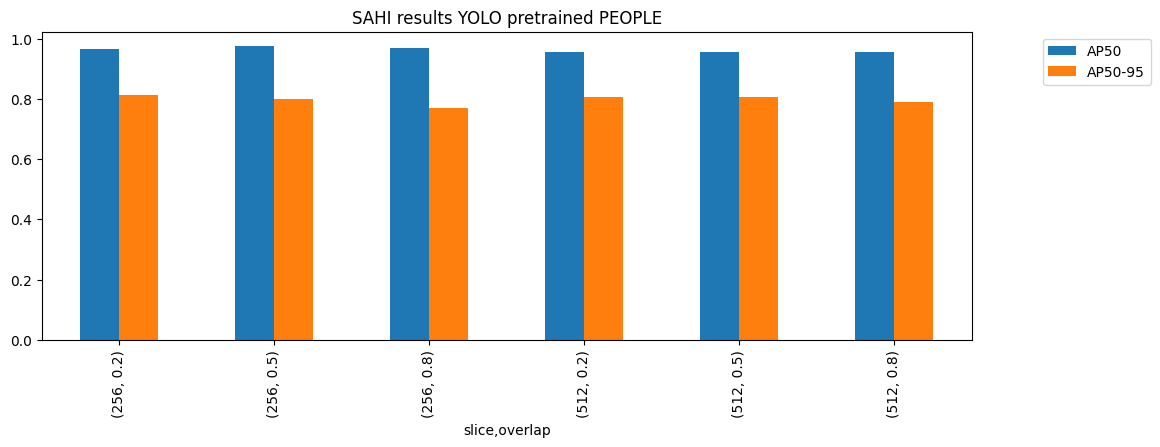

In [97]:
sahi_yolo_pretrained_people.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results YOLO pretrained PEOPLE");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

### Compute metrics for SAHI (YOLOv8 finetuned) on PEOPLE

In [ ]:
sahi_yolo_finetuned_people = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(6))

sahi_yolo_finetuned_people = compute_metrics(sahi_yolo_finetuned_people,
                                            "runs/predict/yolo_people_finetuned",
                                            "people_frames_val/annotations.json")

In [ ]:
sahi_yolo_finetuned_people.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_finetuned_people

In [ ]:
sahi_yolo_finetuned_people.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results YOLO finetuned PEOPLE");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

In [129]:
def show_annotations(image_dir, annotations_dir):
    image = cv2.imread(image_dir)

    height, width = image.shape[:2]


    with open(annotations_dir, "r") as f:
        boxes = f.readlines()

    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()




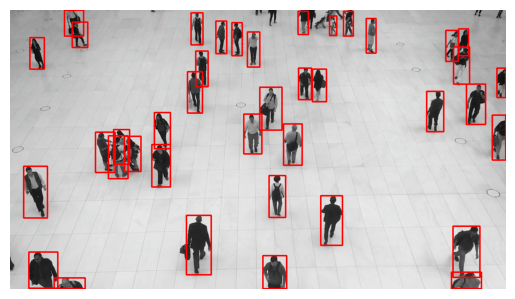

In [130]:
show_annotations("datasets/images/people_frames_113.jpg", "datasets/labels/people_frames_113.txt")